# Memory Agent

## Review

We created a chatbot that saves semantic memories to a single [user profile](https://langchain-ai.github.io/langgraph/concepts/memory/#profile) or [collection](https://langchain-ai.github.io/langgraph/concepts/memory/#collection).

We introduced [Trustcall](https://github.com/hinthornw/trustcall) as a way to update either schema.

## Goals

Now, we're going to pull together the pieces we've learned to build an [agent](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/) with long-term memory.

Our agent, `task_mAIstro`, will help us manage a ToDo list! 

The chatbots we built previously *always* reflected on the conversation and saved memories. 

`task_mAIstro` will decide *when* to save memories (items to our ToDo list).

The chatbots we built previously always saved one type of memory, a profile or a collection. 

`task_mAIstro` can decide to save to either a user profile or a collection of ToDo items.

In addition semantic memory, `task_mAIstro` also will manage procedural memory.

This allows the user to update their preferences for creating ToDo items. 

In [1]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall langchain_core

In [1]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

LANGSMITH_API_KEY:  ········


In [2]:
_set_env("OPENAI_API_KEY")
os.environ["OPENAI_API_VERSION"] = "2024-12-01-preview"
os.environ["ENDPOINT"] = "https://cog-open-ai-lab.openai.azure.com/"
os.environ["MODEL_DEPLOYMENT"] = "gpt-4o"
os.environ["MODEL_NAME"] = "gpt-4o"

OPENAI_API_KEY:  ········


## Visibility into Trustcall updates

Trustcall creates and updates JSON schemas.

What if we want visibility into the *specific changes* made by Trustcall?

For example, we saw before that Trustcall has some of its own tools to:

* Self-correct from validation failures -- [see trace example here](https://smith.langchain.com/public/5cd23009-3e05-4b00-99f0-c66ee3edd06e/r/9684db76-2003-443b-9aa2-9a9dbc5498b7) 
* Update existing documents -- [see trace example here](https://smith.langchain.com/public/f45bdaf0-6963-4c19-8ec9-f4b7fe0f68ad/r/760f90e1-a5dc-48f1-8c34-79d6a3414ac3)

Visibility into these tools can be useful for the agent we're going to build.

Below, we'll show how to do this!

In [3]:
from pydantic import BaseModel, Field

class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories about the user.")

We can add a [listener](https://python.langchain.com/docs/how_to/lcel_cheatsheet/#add-lifecycle-listeners) to the Trustcall extractor.

This will pass runs from the extractor's execution to a class, `Spy`, that we will define.

Our `Spy` class will extract information about what tool calls were made by Trustcall.

In [4]:
from trustcall import create_extractor
from langchain_openai import AzureChatOpenAI
import os

# Inspect the tool calls made by Trustcall
class Spy:
    def __init__(self):
        self.called_tools = []

    def __call__(self, run):
        # Collect information about the tool calls made by the extractor.
        q = [run]
        while q:
            r = q.pop()
            if r.child_runs:
                q.extend(r.child_runs)
            if r.run_type == "chat_model":
                self.called_tools.append(
                    r.outputs["generations"][0][0]["message"]["kwargs"]["tool_calls"]
                )

# Initialize the spy
spy = Spy()

# Initialize the model
model = AzureChatOpenAI(
    openai_api_version=os.getenv('OPENAI_API_VERSION'),
    azure_endpoint=os.getenv('ENDPOINT'),
    azure_deployment=os.getenv('MODEL_DEPLOYMENT'),
    model=os.getenv('MODEL_NAME'),
    temperature=0
)

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

# Add the spy as a listener
trustcall_extractor_see_all_tool_calls = trustcall_extractor.with_listeners(on_end=spy)

In [5]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="hi, i am jessica."), 
                AIMessage(content="Nice to meet you, Jessica."), 
                HumanMessage(content="today i finished reading Dracula")]

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [6]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_mXw22X9K5TZdJH65SGBBWdbI)
 Call ID: call_mXw22X9K5TZdJH65SGBBWdbI
  Args:
    content: Jessica finished reading Dracula today.


In [7]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='Jessica finished reading Dracula today.'


In [8]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_mXw22X9K5TZdJH65SGBBWdbI'}


In [9]:
# Update the conversation
updated_conversation = [AIMessage(content="That's great, did you do after?"), 
                        HumanMessage(content="i started reading Frankenstein"),                        
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="i was thinking about his movie that's currently showing. i really want to see it."),]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0', 'Memory', {'content': 'Jessica finished reading Dracula today.'})]

In [10]:
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor_see_all_tool_calls.invoke({"messages": updated_conversation, 
                                                        "existing": existing_memories})

In [11]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_r9WgqS7kN53d7gqMDReLP9x6', 'json_doc_id': '0'}
{'id': 'call_hMUUGFEOl8SytDF94HHTrbFr'}


In [12]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_r9WgqS7kN53d7gqMDReLP9x6)
 Call ID: call_r9WgqS7kN53d7gqMDReLP9x6
  Args:
    content: Jessica started reading Frankenstein after finishing Dracula.
  Memory (call_hMUUGFEOl8SytDF94HHTrbFr)
 Call ID: call_hMUUGFEOl8SytDF94HHTrbFr
  Args:
    content: Jessica is interested in watching a movie that's currently showing.


In [13]:
# Parsed responses
for m in result["responses"]:
    print(m)

content='Jessica started reading Frankenstein after finishing Dracula.'
content="Jessica is interested in watching a movie that's currently showing."


In [14]:
# Inspect the tool calls made by Trustcall
spy.called_tools

[[{'name': 'PatchDoc',
   'args': {'json_doc_id': '0',
    'planned_edits': "Update the memory content to include the user's new activity of starting to read Frankenstein.",
    'patches': [{'op': 'replace',
      'path': '/content',
      'value': 'Jessica started reading Frankenstein after finishing Dracula.'}]},
   'id': 'call_r9WgqS7kN53d7gqMDReLP9x6',
   'type': 'tool_call'},
  {'name': 'Memory',
   'args': {'content': "Jessica is interested in watching a movie that's currently showing."},
   'id': 'call_hMUUGFEOl8SytDF94HHTrbFr',
   'type': 'tool_call'}]]

In [15]:
def extract_tool_info(tool_calls, schema_name="Memory"):
    """Extract information from tool calls for both patches and new memories.
    
    Args:
        tool_calls: List of tool calls from the model
        schema_name: Name of the schema tool (e.g., "Memory", "ToDo", "Profile")
    """

    # Initialize list of changes
    changes = []
    
    for call_group in tool_calls:
        for call in call_group:
            if call['name'] == 'PatchDoc':
                changes.append({
                    'type': 'update',
                    'doc_id': call['args']['json_doc_id'],
                    'planned_edits': call['args']['planned_edits'],
                    'value': call['args']['patches'][0]['value']
                })
            elif call['name'] == schema_name:
                changes.append({
                    'type': 'new',
                    'value': call['args']
                })

    # Format results as a single string
    result_parts = []
    for change in changes:
        if change['type'] == 'update':
            result_parts.append(
                f"Document {change['doc_id']} updated:\n"
                f"Plan: {change['planned_edits']}\n"
                f"Added content: {change['value']}"
            )
        else:
            result_parts.append(
                f"New {schema_name} created:\n"
                f"Content: {change['value']}"
            )
    
    return "\n\n".join(result_parts)

# Inspect spy.called_tools to see exactly what happened during the extraction
schema_name = "Memory"
changes = extract_tool_info(spy.called_tools, schema_name)
print(changes)

Document 0 updated:
Plan: Update the memory content to include the user's new activity of starting to read Frankenstein.
Added content: Jessica started reading Frankenstein after finishing Dracula.

New Memory created:
Content: {'content': "Jessica is interested in watching a movie that's currently showing."}


## Creating an agent

There are many different [agent](https://langchain-ai.github.io/langgraph/concepts/high_level/) architectures to choose from.

Here, we'll implement something simple, a [ReAct](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-implementation) agent.

This agent will be a helpful companion for creating and managing a ToDo list.

This agent can make a decision to update three types of long-term memory: 

(a) Create or update a user `profile` with general user information 

(b) Add or update items in a ToDo list `collection`

(c) Update its own `instructions` on how to update items to the ToDo list

In [16]:
from typing import TypedDict, Literal

# Update memory tool
class UpdateMemory(TypedDict):
    """ Decision on what memory type to update """
    update_type: Literal['user', 'todo', 'instructions']

In [17]:
_set_env("OPENAI_API_KEY")
os.environ["OPENAI_API_VERSION"] = "2024-12-01-preview"
os.environ["ENDPOINT"] = "https://cog-open-ai-lab.openai.azure.com/"
os.environ["MODEL_DEPLOYMENT"] = "gpt-4o"
os.environ["MODEL_NAME"] = "gpt-4o"

## Graph definition 

We add a simple router, `route_message`, that makes a binary decision to save memories.

The memory collection updating is handled by `Trustcall` in the `write_memory` node, as before!

/var/folders/7z/wbm1wwyx7c725wqb3_cdkbm80000gn/T/ipykernel_94161/331690932.py:52: PydanticDeprecatedSince20: `min_items` is deprecated and will be removed, use `min_length` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  solutions: list[str] = Field(


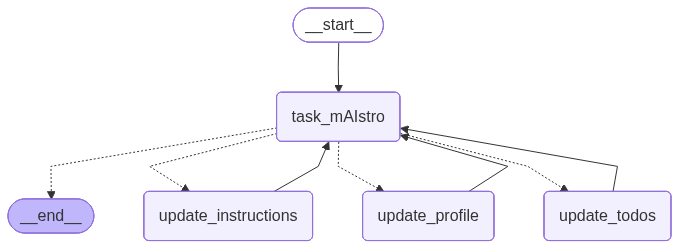

In [18]:
import uuid
from IPython.display import Image, display

from datetime import datetime
from trustcall import create_extractor
from typing import Optional
from pydantic import BaseModel, Field

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import merge_message_runs, HumanMessage, SystemMessage

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

from langchain_openai import AzureChatOpenAI
import os

# Initialize the model
model = AzureChatOpenAI(
    openai_api_version=os.getenv('OPENAI_API_VERSION'),
    azure_endpoint=os.getenv('ENDPOINT'),
    azure_deployment=os.getenv('MODEL_DEPLOYMENT'),
    model=os.getenv('MODEL_NAME'),
    temperature=0
)

# User profile schema
class Profile(BaseModel):
    """This is the profile of the user you are chatting with"""
    name: Optional[str] = Field(description="The user's name", default=None)
    location: Optional[str] = Field(description="The user's location", default=None)
    job: Optional[str] = Field(description="The user's job", default=None)
    connections: list[str] = Field(
        description="Personal connection of the user, such as family members, friends, or coworkers",
        default_factory=list
    )
    interests: list[str] = Field(
        description="Interests that the user has", 
        default_factory=list
    )

# ToDo schema
class ToDo(BaseModel):
    task: str = Field(description="The task to be completed.")
    time_to_complete: Optional[int] = Field(description="Estimated time to complete the task (minutes).")
    deadline: Optional[datetime] = Field(
        description="When the task needs to be completed by (if applicable)",
        default=None
    )
    solutions: list[str] = Field(
        description="List of specific, actionable solutions (e.g., specific ideas, service providers, or concrete options relevant to completing the task)",
        min_items=1,
        default_factory=list
    )
    status: Literal["not started", "in progress", "done", "archived"] = Field(
        description="Current status of the task",
        default="not started"
    )

# Create the Trustcall extractor for updating the user profile 
profile_extractor = create_extractor(
    model,
    tools=[Profile],
    tool_choice="Profile",
)

# Chatbot instruction for choosing what to update and what tools to call 
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. 

You are designed to be a companion to a user, helping them keep track of their ToDo list.

You have a long term memory which keeps track of three things:
1. The user's profile (general information about them) 
2. The user's ToDo list
3. General instructions for updating the ToDo list

Here is the current User Profile (may be empty if no information has been collected yet):
<user_profile>
{user_profile}
</user_profile>

Here is the current ToDo List (may be empty if no tasks have been added yet):
<todo>
{todo}
</todo>

Here are the current user-specified preferences for updating the ToDo list (may be empty if no preferences have been specified yet):
<instructions>
{instructions}
</instructions>

Here are your instructions for reasoning about the user's messages:

1. Reason carefully about the user's messages as presented below. 

2. Decide whether any of the your long-term memory should be updated:
- If personal information was provided about the user, update the user's profile by calling UpdateMemory tool with type `user`
- If tasks are mentioned, update the ToDo list by calling UpdateMemory tool with type `todo`
- If the user has specified preferences for how to update the ToDo list, update the instructions by calling UpdateMemory tool with type `instructions`

3. Tell the user that you have updated your memory, if appropriate:
- Do not tell the user you have updated the user's profile
- Tell the user them when you update the todo list
- Do not tell the user that you have updated instructions

4. Err on the side of updating the todo list. No need to ask for explicit permission.

5. Respond naturally to user user after a tool call was made to save memories, or if no tool call was made."""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously.

System Time: {time}"""

# Instructions for updating the ToDo list
CREATE_INSTRUCTIONS = """Reflect on the following interaction.

Based on this interaction, update your instructions for how to update ToDo list items. 

Use any feedback from the user to update how they like to have items added, etc.

Your current instructions are:

<current_instructions>
{current_instructions}
</current_instructions>"""

# Node definitions
def task_mAIstro(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve profile memory from the store
    namespace = ("profile", user_id)
    memories = store.search(namespace)
    if memories:
        user_profile = memories[0].value
    else:
        user_profile = None

    # Retrieve task memory from the store
    namespace = ("todo", user_id)
    memories = store.search(namespace)
    todo = "\n".join(f"{mem.value}" for mem in memories)

    # Retrieve custom instructions
    namespace = ("instructions", user_id)
    memories = store.search(namespace)
    if memories:
        instructions = memories[0].value
    else:
        instructions = ""
    
    system_msg = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile, todo=todo, instructions=instructions)

    # Respond using memory as well as the chat history
    response = model.bind_tools([UpdateMemory], parallel_tool_calls=False).invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": [response]}

def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("profile", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Profile"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Invoke the extractor
    result = profile_extractor.invoke({"messages": updated_messages, 
                                         "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated profile", "tool_call_id":tool_calls[0]['id']}]}

def update_todos(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("todo", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "ToDo"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Initialize the spy for visibility into the tool calls made by Trustcall
    spy = Spy()
    
    # Create the Trustcall extractor for updating the ToDo list 
    todo_extractor = create_extractor(
    model,
    tools=[ToDo],
    tool_choice=tool_name,
    enable_inserts=True
    ).with_listeners(on_end=spy)

    # Invoke the extractor
    result = todo_extractor.invoke({"messages": updated_messages, 
                                    "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
        
    # Respond to the tool call made in task_mAIstro, confirming the update
    tool_calls = state['messages'][-1].tool_calls

    # Extract the changes made by Trustcall and add the the ToolMessage returned to task_mAIstro
    todo_update_msg = extract_tool_info(spy.called_tools, tool_name)
    return {"messages": [{"role": "tool", "content": todo_update_msg, "tool_call_id":tool_calls[0]['id']}]}

def update_instructions(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]
    
    namespace = ("instructions", user_id)

    existing_memory = store.get(namespace, "user_instructions")
        
    # Format the memory in the system prompt
    system_msg = CREATE_INSTRUCTIONS.format(current_instructions=existing_memory.value if existing_memory else None)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'][:-1] + [HumanMessage(content="Please update the instructions based on the conversation")])

    # Overwrite the existing memory in the store 
    key = "user_instructions"
    store.put(namespace, key, {"memory": new_memory.content})
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated instructions", "tool_call_id":tool_calls[0]['id']}]}

# Conditional edge
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_todos", "update_instructions", "update_profile"]:

    """Reflect on the memories and chat history to decide whether to update the memory collection."""
    message = state['messages'][-1]
    if len(message.tool_calls) ==0:
        return END
    else:
        tool_call = message.tool_calls[0]
        if tool_call['args']['update_type'] == "user":
            return "update_profile"
        elif tool_call['args']['update_type'] == "todo":
            return "update_todos"
        elif tool_call['args']['update_type'] == "instructions":
            return "update_instructions"
        else:
            raise ValueError

# Create the graph + all nodes
builder = StateGraph(MessagesState)

# Define the flow of the memory extraction process
builder.add_node(task_mAIstro)
builder.add_node(update_todos)
builder.add_node(update_profile)
builder.add_node(update_instructions)
builder.add_edge(START, "task_mAIstro")
builder.add_conditional_edges("task_mAIstro", route_message)
builder.add_edge("update_todos", "task_mAIstro")
builder.add_edge("update_profile", "task_mAIstro")
builder.add_edge("update_instructions", "task_mAIstro")

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [19]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "guilherme"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="my name is guilherme. i live in SP with my wife. i have a 1 year old daughter.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

my name is guilherme. i live in SP with my wife. i have a 1 year old daughter.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_HCGyaPJOKXHT0bIKOYHkbtJB)
 Call ID: call_HCGyaPJOKXHT0bIKOYHkbtJB
  Args:
    update_type: user
================================= Tool Message =================================

updated profile
================================== Ai Message ==================================

Got it, Guilherme! How can I assist you today?


In [20]:
# User input for a ToDo
input_messages = [HumanMessage(content="my wife asked me to book swim lessons for the baby.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

my wife asked me to book swim lessons for the baby.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_JbeYGuv67kVk8gf64foXskuM)
 Call ID: call_JbeYGuv67kVk8gf64foXskuM
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Book swim lessons for the baby.', 'time_to_complete': 30, 'solutions': ['Research local swim schools in SP.', 'Check reviews and ratings of swim schools.', 'Contact swim schools for availability and pricing.', 'Book a suitable time slot for the lessons.'], 'status': 'not started'}
================================== Ai Message ==================================

I've added "Book swim lessons for the baby" to your ToDo list. Let me know if there's anything else you'd like to add or adjust!


In [21]:
# User input to update instructions for creating ToDos
input_messages = [HumanMessage(content="When creating or updating ToDo items, include specific local businesses / vendors.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

When creating or updating ToDo items, include specific local businesses / vendors.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_W62UT59apz7MWZBOdR6jlGX3)
 Call ID: call_W62UT59apz7MWZBOdR6jlGX3
  Args:
    update_type: instructions
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

Understood! I'll make sure to include specific local businesses or vendors when creating or updating your ToDo items. Let me know if there's anything else you'd like to adjust!


In [22]:
# Check for updated instructions
user_id = "guilherme"

# Search 
for memory in across_thread_memory.search(("instructions", user_id)):
    print(memory.value)

{'memory': 'Here are the updated instructions for creating or updating ToDo list items:\n\n<current_instructions>\nWhen creating or updating ToDo items:\n1. Include specific local businesses or vendors relevant to the task, especially if the user provides location details.\n2. Provide actionable steps or solutions to complete the task.\n3. Ensure the task status is clearly marked (e.g., "not started," "in progress," or "completed").\n4. Tailor the task details to the user\'s preferences or requests.\n</current_instructions>'}


In [23]:
# User input for a ToDo
input_messages = [HumanMessage(content="i need to fix the kitchen cabinet door.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

i need to fix the kitchen cabinet door.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_5J4dVdcXlIHV9XedN6XCzreq)
 Call ID: call_5J4dVdcXlIHV9XedN6XCzreq
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Fix the kitchen cabinet door.', 'time_to_complete': 60, 'solutions': ['Identify the issue with the cabinet door (e.g., loose hinge, broken part).', 'Purchase necessary tools or replacement parts from a local hardware store (e.g., Leroy Merlin, Telhanorte).', 'Follow an online tutorial or hire a handyman to fix the door.'], 'status': 'not started'}

Document e023c1eb-408a-4470-9bfd-0f8a45344e43 updated:
Plan: Add specific local swim schools in SP to the solutions list.
Added content: ['Research local swim schools in SP (e.g., Swim Center SP, Ac

In [24]:
# Namespace for the memory to save
user_id = "guilherme"

# Search 
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'task': 'Book swim lessons for the baby.', 'time_to_complete': 30, 'deadline': None, 'solutions': ['Research local swim schools in SP (e.g., Swim Center SP, Acqua Fit, or Natação Baby).', 'Check reviews and ratings of swim schools.', 'Contact swim schools for availability and pricing.', 'Book a suitable time slot for the lessons.'], 'status': 'not started'}
{'task': 'Fix the kitchen cabinet door.', 'time_to_complete': 60, 'deadline': None, 'solutions': ['Identify the issue with the cabinet door (e.g., loose hinge, broken part).', 'Purchase necessary tools or replacement parts from a local hardware store (e.g., Leroy Merlin, Telhanorte).', 'Follow an online tutorial or hire a handyman to fix the door.'], 'status': 'not started'}


In [25]:
# User input to update an existing ToDo
input_messages = [HumanMessage(content="for the swim lessons, i need to get that done by end of november.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

for the swim lessons, i need to get that done by end of november.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_1LRWNrcm1qXQhrg4uy1xw6Tq)
 Call ID: call_1LRWNrcm1qXQhrg4uy1xw6Tq
  Args:
    update_type: todo
================================= Tool Message =================================

Document e023c1eb-408a-4470-9bfd-0f8a45344e43 updated:
Plan: Update the deadline for the swim lessons task to the end of November.
Added content: 2025-11-30T23:59:59

New ToDo created:
Content: {'task': 'Book swim lessons for the baby.', 'time_to_complete': 30, 'deadline': '2025-11-30T23:59:59', 'solutions': ['Research local swim schools in SP (e.g., Swim Center SP, Acqua Fit, or Natação Baby).', 'Check reviews and ratings of swim schools.', 'Contact swim schools for availability and pricing.', 'Book a suitable time slot for the lessons.'], 'status': 'no

We can see that Trustcall performs patching of the existing memory:

https://smith.langchain.com/public/4ad3a8af-3b1e-493d-b163-3111aa3d575a/r

In [26]:
# User input for a ToDo
input_messages = [HumanMessage(content="need to call back civic to schedule car service.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

need to call back civic to schedule car service.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_LXfmvqJh56S6uAI1boYyHE2h)
 Call ID: call_LXfmvqJh56S6uAI1boYyHE2h
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Call back Civic to schedule car service.', 'time_to_complete': 15, 'solutions': ['Find the contact number for Civic service center.', 'Call the service center to inquire about available slots.', 'Schedule a convenient time for the car service.'], 'status': 'not started'}
================================== Ai Message ==================================

I've added "Call back Civic to schedule car service" to your ToDo list. Let me know if there's anything else you'd like to add or update!


In [27]:
# Namespace for the memory to save
user_id = "guilherme"

# Search 
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'task': 'Book swim lessons for the baby.', 'time_to_complete': 30, 'deadline': '2025-11-30T23:59:59', 'solutions': ['Research local swim schools in SP (e.g., Swim Center SP, Acqua Fit, or Natação Baby).', 'Check reviews and ratings of swim schools.', 'Contact swim schools for availability and pricing.', 'Book a suitable time slot for the lessons.'], 'status': 'not started'}
{'task': 'Fix the kitchen cabinet door.', 'time_to_complete': 60, 'deadline': None, 'solutions': ['Identify the issue with the cabinet door (e.g., loose hinge, broken part).', 'Purchase necessary tools or replacement parts from a local hardware store (e.g., Leroy Merlin, Telhanorte).', 'Follow an online tutorial or hire a handyman to fix the door.'], 'status': 'not started'}
{'task': 'Book swim lessons for the baby.', 'time_to_complete': 30, 'deadline': '2025-11-30T23:59:59', 'solutions': ['Research local swim schools in SP (e.g., Swim Center SP, Acqua Fit, or Natação Baby).', 'Check reviews and ratings of swim sch

Now we can create a new thread.

This creates a new session. 

Profile, ToDos, and Instructions saved to long-term memory are accessed. 

In [28]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "guilherme"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="i have 30 minutes, what tasks can i get done?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

i have 30 minutes, what tasks can i get done?
================================== Ai Message ==================================

Looking at your ToDo list, here are the tasks you can complete in 30 minutes:

1. **Book swim lessons for the baby** (30 minutes):
   - Research local swim schools in São Paulo (e.g., Swim Center SP, Acqua Fit, or Natação Baby).
   - Check reviews and ratings of swim schools.
   - Contact swim schools for availability and pricing.
   - Book a suitable time slot for the lessons.

2. **Call back Civic to schedule car service** (15 minutes):
   - Find the contact number for Civic service center.
   - Call the service center to inquire about available slots.
   - Schedule a convenient time for the car service.

You can complete one of these tasks or even both if you manage your time well! Let me know if you'd like help prioritizing or tackling one of them.


In [29]:
# Chat with the chatbot
input_messages = [HumanMessage(content="yes, give me some options to call for swim lessons.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

yes, give me some options to call for swim lessons.
================================== Ai Message ==================================

Here are some swim schools in São Paulo that you can consider contacting for swim lessons for your baby:

1. **Swim Center SP**  
   - Known for offering specialized swim lessons for babies and toddlers.  
   - Check their website or call them to inquire about availability and pricing.

2. **Acqua Fit**  
   - Offers baby swimming classes with a focus on safety and fun.  
   - You can look up reviews online and contact them for more details.

3. **Natação Baby**  
   - A popular choice for baby swimming lessons in São Paulo.  
   - They may have flexible schedules and experienced instructors.

You can start by researching these options online, checking reviews, and calling them to ask about their programs, pricing, and available time slots. Let me know if you'd like me to a

Trace: 

https://smith.langchain.com/public/84768705-be91-43e4-8a6f-f9d3cee93782/r

## Studio

![Screenshot 2024-11-04 at 1.00.19 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/6732cfb05d9709862eba4e6c_Screenshot%202024-11-11%20at%207.46.40%E2%80%AFPM.png)